Epoch 1/200 - Train: MSE=71.3606, RMSE=8.4475, MAE=7.6577, R2=-2.9330 | Test: MSE=48.7010, RMSE=6.9786, MAE=6.2937, R2=-1.6418
Epoch 2/200 - Train: MSE=38.8700, RMSE=6.2346, MAE=5.5223, R2=-1.1423 | Test: MSE=24.3047, RMSE=4.9300, MAE=4.2935, R2=-0.3184
Epoch 3/200 - Train: MSE=17.7792, RMSE=4.2165, MAE=3.5555, R2=0.0201 | Test: MSE=10.2948, RMSE=3.2086, MAE=2.6563, R2=0.4416
Epoch 4/200 - Train: MSE=9.2448, RMSE=3.0405, MAE=2.4507, R2=0.4905 | Test: MSE=6.7098, RMSE=2.5903, MAE=2.0579, R2=0.6360
Epoch 5/200 - Train: MSE=7.6700, RMSE=2.7695, MAE=2.1736, R2=0.5773 | Test: MSE=6.2915, RMSE=2.5083, MAE=1.9654, R2=0.6587
Epoch 6/200 - Train: MSE=7.3443, RMSE=2.7100, MAE=2.1293, R2=0.5952 | Test: MSE=6.0171, RMSE=2.4530, MAE=1.8999, R2=0.6736
Epoch 7/200 - Train: MSE=7.1506, RMSE=2.6741, MAE=2.0821, R2=0.6059 | Test: MSE=5.9720, RMSE=2.4438, MAE=1.8838, R2=0.6760
Epoch 8/200 - Train: MSE=7.1902, RMSE=2.6814, MAE=2.0772, R2=0.6037 | Test: MSE=5.8410, RMSE=2.4168, MAE=1.8817, R2=0.6832
Epoch 

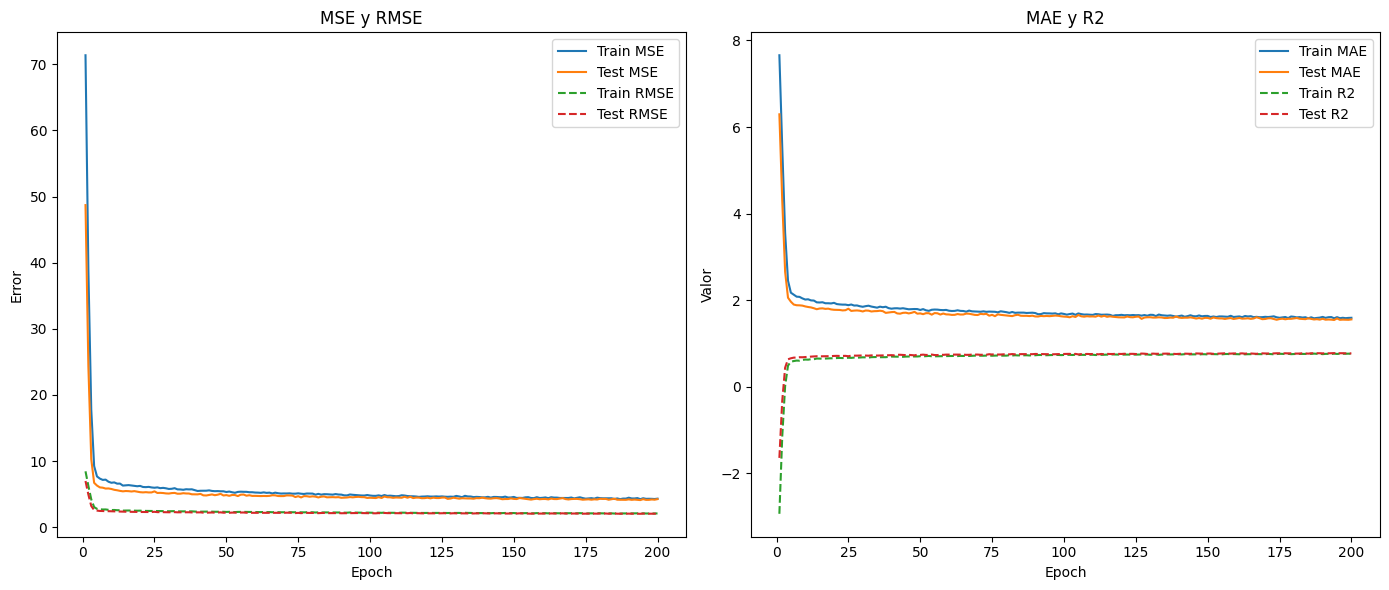

In [36]:
#MLP
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt
import time

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "Par.csv"   # tu CSV
TARGET_COL = "(seco)Masa de rend.(tonne/ha)"
TEST_SIZE = 0.2
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Entrenamiento
EPOCHS = 200
BATCH_SIZE = 128
LR = 0.001

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ----------------------------
# Carga de datos
# ----------------------------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=['parcela'])
cat_cols = ['Cal sing', 'Rate Qual']
df = pd.get_dummies(df, columns=cat_cols)

if TARGET_COL not in df.columns:
    raise ValueError(f"No encontré la columna target '{TARGET_COL}'")

X = df[['Flujo de semilla(ksds/s)', 'Cta. semillas((1))', 'Dobles(%)', 'Prop. meta(ksds/ha)', 'Cant. prod.', 'Humedad(%)', 'Temp. grano(°C)', 'Countrate', 'B', 'Ca_Mg', 'Clay', 'Cu', 'Fe', 'K', 'Leak', 'Loam', 'Mg', 'Na', 'OM', 'PAWater', 'pH', 'Sand', 'Silt', 'Zn', 'ndvi', 'Cal sing_Bueno', 'Cal sing_Salto', 'GNDVI', 'NDMI', 'NDRE', 'SAVI']]
y = df[TARGET_COL].astype(float).values

# Escalado
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Modelo
# ----------------------------
class CustomMLP(nn.Module):
    def __init__(self, input_dim, n1=64, n2=256, n3=64, dropout1=0.1, dropout2=0.3, dropout3=0.1):
        super(CustomMLP, self).__init__()

        # Capa 1
        self.fc1 = nn.Linear(input_dim, n1)
        self.bn1 = nn.BatchNorm1d(n1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout1)

        # Capa 2
        self.fc2 = nn.Linear(n1, n2)
        self.bn2 = nn.BatchNorm1d(n2)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout2)

        # Capa 3
        self.fc3 = nn.Linear(n2, n3)
        self.bn3 = nn.BatchNorm1d(n3)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout3)

        # Capa de salida
        self.fc_out = nn.Linear(n3, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.drop3(x)

        x = self.fc_out(x)
        return x.squeeze(1)

model = CustomMLP(input_dim=X_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# ----------------------------
# Entrenamiento con curva de aprendizaje
# ----------------------------
train_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}
test_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}

start = time.time()
for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    y_train_pred = []
    y_train_true = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        y_train_pred.append(preds.detach().cpu().numpy())
        y_train_true.append(yb.cpu().numpy())

    y_train_pred = np.concatenate(y_train_pred)
    y_train_true = np.concatenate(y_train_true)
    train_mse = mean_squared_error(y_train_true, y_train_pred)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = math.sqrt(train_mse)
    train_r2 = r2_score(y_train_true, y_train_pred)

    # Test
    model.eval()
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_pred_test.append(preds.cpu().numpy())
            y_true_test.append(yb.cpu().numpy())
    y_pred_test = np.concatenate(y_pred_test)
    y_true_test = np.concatenate(y_true_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = math.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Guardar métricas para curva
    train_metrics['mse'].append(train_mse)
    train_metrics['rmse'].append(train_rmse)
    train_metrics['mae'].append(train_mae)
    train_metrics['r2'].append(train_r2)

    test_metrics['mse'].append(test_mse)
    test_metrics['rmse'].append(test_rmse)
    test_metrics['mae'].append(test_mae)
    test_metrics['r2'].append(test_r2)

    print(f"Epoch {epoch}/{EPOCHS} - "
          f"Train: MSE={train_mse:.4f}, RMSE={train_rmse:.4f}, MAE={train_mae:.4f}, R2={train_r2:.4f} | "
          f"Test: MSE={test_mse:.4f}, RMSE={test_rmse:.4f}, MAE={test_mae:.4f}, R2={test_r2:.4f}")

elapsed = time.time() - start
print(f"\nEntrenamiento completado en {elapsed/60:.2f} minutos")

# ----------------------------
# Curvas de aprendizaje
# ----------------------------
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(14, 6))

# MSE y RMSE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_metrics['mse'], label='Train MSE')
plt.plot(epochs_range, test_metrics['mse'], label='Test MSE')
plt.plot(epochs_range, train_metrics['rmse'], '--', label='Train RMSE')
plt.plot(epochs_range, test_metrics['rmse'], '--', label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE y RMSE')
plt.legend()

# MAE y R2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_metrics['mae'], label='Train MAE')
plt.plot(epochs_range, test_metrics['mae'], label='Test MAE')
plt.plot(epochs_range, train_metrics['r2'], '--', label='Train R2')
plt.plot(epochs_range, test_metrics['r2'], '--', label='Test R2')
plt.xlabel('Epoch')
plt.ylabel('Valor')
plt.title('MAE y R2')
plt.legend()

plt.tight_layout()
plt.show()


Dimensiones de X: (10830, 47)
Columnas de X: ['Flujo de semilla(ksds/s)', 'Cta. semillas((1))', 'Singulación(%)', 'Saltos(%)', 'Dobles(%)', 'Separación adecuada(%)', 'Pob. plantas(ksds/ha)', 'Vacío(inH2O)', 'Prop. meta(ksds/ha)', 'Prop. ap. cta.(ksds/ha)', 'Espacio entre semillas(cm)', 'Cant. prod.', '% densidad(%)', 'Humedad(%)', 'Temp. grano(°C)', 'Countrate', 'B', 'Ca', 'Ca_Mg', 'Clay', 'Cu', 'Fe', 'K', 'Leak', 'Loam', 'Mg', 'Mn', 'Na', 'OM', 'P', 'PAWater', 'pH', 'S', 'Sand', 'Silt', 'Zn', 'ndvi', 'GNDVI', 'NDRE', 'NDMI', 'SAVI', 'Cal sing_Bueno', 'Cal sing_Doble', 'Cal sing_Salto', 'Rate Qual_Bajo Objetivo', 'Rate Qual_Bien', 'Rate Qual_Sobre el objetivo']
Modelo ANFIS creado con 20601 parámetros
Hiperparámetros: MFs=2, Hidden=118, Dropout=0.3, WD=0.001
Epoch 1/500 - LR: 0.00100000
  Train - MSE: 73.1524, RMSE: 8.5529, MAE: 7.6706, R²: -3.0317
  Test  - MSE: 65.3453, RMSE: 8.0836, MAE: 7.3154, R²: -2.5447
  Gap Train-Test: MSE=+7.8070, RMSE=+0.4693

Epoch 2/500 - LR: 0.00100000
  

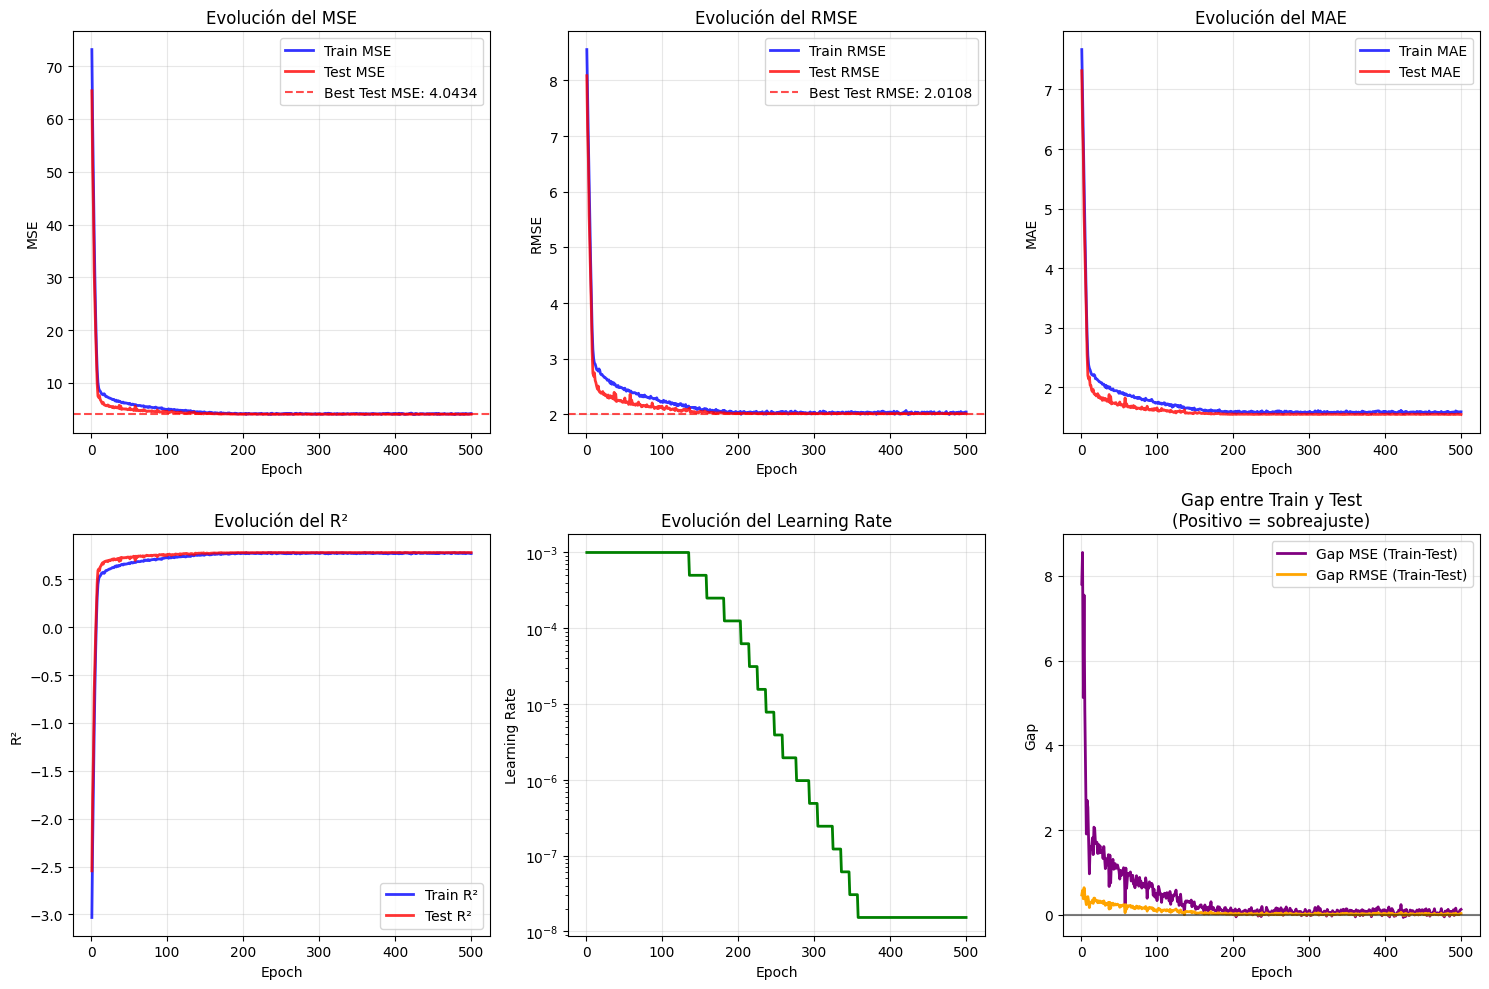

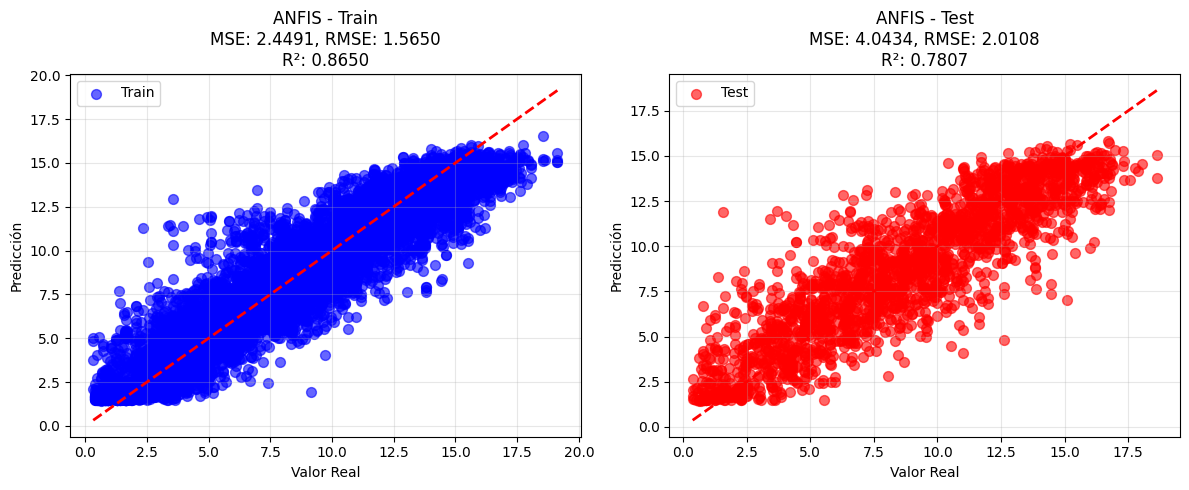


RESUMEN FINAL DE MÉTRICAS ANFIS
Métrica         Train        Test         Gap         
------------------------------------------------------------
MSE             2.4491     4.0434     -1.5942
RMSE            1.5650     2.0108     -0.4458
MAE             1.1930     1.5402     -0.3472
R²              0.8650     0.7807     +0.0844

🔍 ANÁLISIS DE SOBREAJUSTE:
   Gap RMSE (Train-Test): -0.4458
 SIN SOBREAJUSTE 

💡 Hiperparámetros actuales:
   • NUM_MFS = 2
   • HIDDEN_DIM = 118
   • DROPOUT_RATE = 0.3
   • WEIGHT_DECAY = 0.001
   • BATCH_SIZE = 256


In [11]:
#NeuroDifuso
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt
import time

# ----------------------------
# Config con Hiperparámetros Ajustables
# ----------------------------
CSV_PATH = "Par.csv"
TARGET_COL = "(seco)Masa de rend.(tonne/ha)"
TEST_SIZE = 0.2
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# HIPERPARÁMETROS AJUSTABLES
EPOCHS = 500
BATCH_SIZE = 256
LR = 0.001
NUM_MFS = 2
HIDDEN_DIM = 118
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-3

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ----------------------------
# Carga de datos
# ----------------------------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=['parcela'])
cat_cols = ['Cal sing', 'Rate Qual']
df = pd.get_dummies(df, columns=cat_cols)

if TARGET_COL not in df.columns:
    raise ValueError(f"No encontré la columna target '{TARGET_COL}'")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float).values

print(f"Dimensiones de X: {X.shape}")
print(f"Columnas de X: {list(X.columns)}")

# Escalado
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Modelo ANFIS
# ----------------------------
class RegularizedANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs=2, hidden_dim=128, dropout_rate=0.3):
        super(RegularizedANFIS, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs

        # Inicialización más conservadora de centros y sigmas
        self.centers = nn.Parameter(torch.randn(input_dim, num_mfs) * 0.1)
        self.sigmas = nn.Parameter(torch.ones(input_dim, num_mfs) * 0.8)

        # Arquitectura
        self.fuzzy_net = nn.Sequential(
            nn.Linear(input_dim * num_mfs, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),

            nn.Linear(hidden_dim // 4, 1)
        )

        # Inicialización de pesos
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def gaussian_mf(self, x, centers, sigmas):
        return torch.exp(-0.5 * ((x.unsqueeze(-1) - centers) / (sigmas + 1e-8)) ** 2)

    def forward(self, x):
        batch_size = x.shape[0]
        membership = self.gaussian_mf(x, self.centers, self.sigmas)
        fuzzy_features = membership.view(batch_size, -1)
        output = self.fuzzy_net(fuzzy_features)
        return output.squeeze(1)

# Crear modelo con hiperparámetros
model = RegularizedANFIS(
    input_dim=X_train.shape[1],
    num_mfs=NUM_MFS,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

# Optimizador con weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
loss_fn = nn.MSELoss()

print(f"Modelo ANFIS creado con {sum(p.numel() for p in model.parameters())} parámetros")
print(f"Hiperparámetros: MFs={NUM_MFS}, Hidden={HIDDEN_DIM}, Dropout={DROPOUT_RATE}, WD={WEIGHT_DECAY}")

# ----------------------------
# Entrenamiento
# ----------------------------
train_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}
test_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}
learning_rates = []

start = time.time()
best_test_rmse = float('inf')
best_test_mse = float('inf')

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    y_train_pred = []
    y_train_true = []
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        y_train_pred.append(preds.detach().cpu().numpy())
        y_train_true.append(yb.cpu().numpy())

    # Métricas de entrenamiento
    y_train_pred = np.concatenate(y_train_pred)
    y_train_true = np.concatenate(y_train_true)
    train_mse = mean_squared_error(y_train_true, y_train_pred)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = math.sqrt(train_mse)
    train_r2 = r2_score(y_train_true, y_train_pred)

    # Test
    model.eval()
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_pred_test.append(preds.cpu().numpy())
            y_true_test.append(yb.cpu().numpy())

    y_pred_test = np.concatenate(y_pred_test)
    y_true_test = np.concatenate(y_true_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = math.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Actualizar scheduler
    scheduler.step(test_mse)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Guardamos el mejor modelo
    if test_mse < best_test_mse:
        best_train_mse = train_mse
        best_train_rsme = train_rmse
        best_train_mae = train_mae
        best_train_r2 = train_r2
        best_test_mse = test_mse
        best_test_rmse = test_rmse
        best_test_mae = test_mae
        best_test_r2 = test_r2
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_anfis_model.pth')

    # Guardar métricas
    train_metrics['mse'].append(train_mse)
    train_metrics['rmse'].append(train_rmse)
    train_metrics['mae'].append(train_mae)
    train_metrics['r2'].append(train_r2)

    test_metrics['mse'].append(test_mse)
    test_metrics['rmse'].append(test_rmse)
    test_metrics['mae'].append(test_mae)
    test_metrics['r2'].append(test_r2)

    if epoch % 10 == 0 or epoch <= 5:
        print(f"Epoch {epoch}/{EPOCHS} - LR: {current_lr:.8f}")
        print(f"  Train - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
        print(f"  Test  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
        print(f"  Gap Train-Test: MSE={train_mse-test_mse:+.4f}, RMSE={train_rmse-test_rmse:+.4f}")
        print()

elapsed = time.time() - start
print(f"\nEntrenamiento ANFIS completado en {elapsed/60:.2f} minutos")
print(f"Mejor epoch: {best_epoch}")
print(f"Best MSE: {best_train_mse:.4f}")
print(f"Best RMSE: {best_train_rsme:.4f}")
print(f"Best MAE: {best_train_mae:.4f}")
print(f"Best RMSE: {best_train_r2:.4f}")
print(f"Mejor Test MSE:  {best_test_mse:.4f}")
print(f"Mejor Test RMSE: {best_test_rmse:.4f}")
print(f"Mejor Test MAE:  {best_test_mae:.4f}")
print(f"Mejor Test R2: {best_test_r2:.4f}")

# Cargar el mejor modelo al final
model.load_state_dict(torch.load('best_anfis_model.pth'))

# ----------------------------
# Visualización Completa de Resultados
# ----------------------------
# Asegurarnos que todas las métricas tengan la misma longitud
min_length = min(len(train_metrics['mse']), len(test_metrics['mse']))
epochs_range = range(1, min_length + 1)

# Recortar todas las métricas a la misma longitud
train_metrics_corr = {k: v[:min_length] for k, v in train_metrics.items()}
test_metrics_corr = {k: v[:min_length] for k, v in test_metrics.items()}
learning_rates_corr = learning_rates[:min_length]

plt.figure(figsize=(15, 10))

# MSE y RMSE
plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_metrics_corr['mse'], 'b-', label='Train MSE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['mse'], 'r-', label='Test MSE', linewidth=2, alpha=0.8)
plt.axhline(y=best_test_mse, color='r', linestyle='--', alpha=0.7, label=f'Best Test MSE: {best_test_mse:.4f}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Evolución del MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE
plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_metrics_corr['rmse'], 'b-', label='Train RMSE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['rmse'], 'r-', label='Test RMSE', linewidth=2, alpha=0.8)
plt.axhline(y=best_test_rmse, color='r', linestyle='--', alpha=0.7, label=f'Best Test RMSE: {best_test_rmse:.4f}')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolución del RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE
plt.subplot(2, 3, 3)
plt.plot(epochs_range, train_metrics_corr['mae'], 'b-', label='Train MAE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['mae'], 'r-', label='Test MAE', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Evolución del MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# R²
plt.subplot(2, 3, 4)
plt.plot(epochs_range, train_metrics_corr['r2'], 'b-', label='Train R²', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['r2'], 'r-', label='Test R²', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Evolución del R²')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate
plt.subplot(2, 3, 5)
plt.plot(epochs_range, learning_rates_corr, 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Gap entre train y test (sobreajuste)
plt.subplot(2, 3, 6)
train_test_gap_mse = np.array(train_metrics_corr['mse']) - np.array(test_metrics_corr['mse'])
train_test_gap_rmse = np.array(train_metrics_corr['rmse']) - np.array(test_metrics_corr['rmse'])
plt.plot(epochs_range, train_test_gap_mse, 'purple', label='Gap MSE (Train-Test)', linewidth=2)
plt.plot(epochs_range, train_test_gap_rmse, 'orange', label='Gap RMSE (Train-Test)', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.title('Gap entre Train y Test\n(Positivo = sobreajuste)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Predicciones vs Valores Reales
# ----------------------------
model.eval()
with torch.no_grad():
    y_train_pred_final = model(X_train_t).cpu().numpy()
    y_test_pred_final = model(X_test_t).cpu().numpy()

# Métricas finales detalladas
final_train_mse = mean_squared_error(y_train, y_train_pred_final)
final_test_mse = mean_squared_error(y_test, y_test_pred_final)
final_train_rmse = math.sqrt(final_train_mse)
final_test_rmse = math.sqrt(final_test_mse)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_final, alpha=0.6, s=50, c='blue', label='Train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title(f'ANFIS - Train\nMSE: {final_train_mse:.4f}, RMSE: {final_train_rmse:.4f}\nR²: {r2_score(y_train, y_train_pred_final):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_final, alpha=0.6, s=50, c='red', label='Test')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title(f'ANFIS - Test\nMSE: {final_test_mse:.4f}, RMSE: {final_test_rmse:.4f}\nR²: {r2_score(y_test, y_test_pred_final):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Resumen Final de Métricas
# ----------------------------
print("\n" + "="*60)
print("RESUMEN FINAL DE MÉTRICAS ANFIS")
print("="*60)
print(f"{'Métrica':<15} {'Train':<12} {'Test':<12} {'Gap':<12}")
print("-" * 60)
print(f"{'MSE':<15} {final_train_mse:.4f}     {final_test_mse:.4f}     {final_train_mse-final_test_mse:+.4f}")
print(f"{'RMSE':<15} {final_train_rmse:.4f}     {final_test_rmse:.4f}     {final_train_rmse-final_test_rmse:+.4f}")
print(f"{'MAE':<15} {mean_absolute_error(y_train, y_train_pred_final):.4f}     {mean_absolute_error(y_test, y_test_pred_final):.4f}     {mean_absolute_error(y_train, y_train_pred_final)-mean_absolute_error(y_test, y_test_pred_final):+.4f}")
print(f"{'R²':<15} {r2_score(y_train, y_train_pred_final):.4f}     {r2_score(y_test, y_test_pred_final):.4f}     {r2_score(y_train, y_train_pred_final)-r2_score(y_test, y_test_pred_final):+.4f}")
print("="*60)

# ----------------------------
# Recomendaciones de Hiperparámetros
# ----------------------------
overfitting_gap = final_train_rmse - final_test_rmse
print("\n ANÁLISIS DE SOBREAJUSTE:")
print(f"   Gap RMSE (Train-Test): {overfitting_gap:+.4f}")

if overfitting_gap > 0.1:
    print(" ALTO SOBREAJUSTE ")
elif overfitting_gap > 0.05:
    print(" SOBREAJUSTE MODERADO ")
elif overfitting_gap > 0:
    print(" SOBREAJUSTE LEVE ")
else:
    print(" SIN SOBREAJUSTE ")

print(f"\n Hiperparámetros actuales:")
print(f"   • NUM_MFS = {NUM_MFS}")
print(f"   • HIDDEN_DIM = {HIDDEN_DIM}")
print(f"   • DROPOUT_RATE = {DROPOUT_RATE}")
print(f"   • WEIGHT_DECAY = {WEIGHT_DECAY}")
print(f"   • BATCH_SIZE = {BATCH_SIZE}")

 Cargando datos...
Total características: 47
Continuas: 41, Dummy: 6

 Cargando modelo entrenado...
 Modelo cargado exitosamente!

 ANALIZANDO TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES

 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
     Característica      Tipo  Importancia  Centro_MF1  Sigma_MF1  Centro_MF2  \
14  Temp. grano(°C)  Continua       0.2062     -0.2422     0.3880      0.6079   
37            GNDVI  Continua       0.1006     -0.0151     0.4877      0.4479   
13       Humedad(%)  Continua       0.0853     -0.2633     1.0548      0.8549   
17               Ca  Continua       0.0687     -0.0269     0.7922      0.2209   
27               Na  Continua       0.0636     -0.0646     0.7377     -0.1376   
28               OM  Continua       0.0585     -0.3373     0.5774      0.1394   
16                B  Continua       0.0510     -0.0537     0.6355     -0.0769   
11      Cant. prod.  Continua       0.0383     -0.0701     0.6485      0.2794   
22                K  Continua       0.0348     

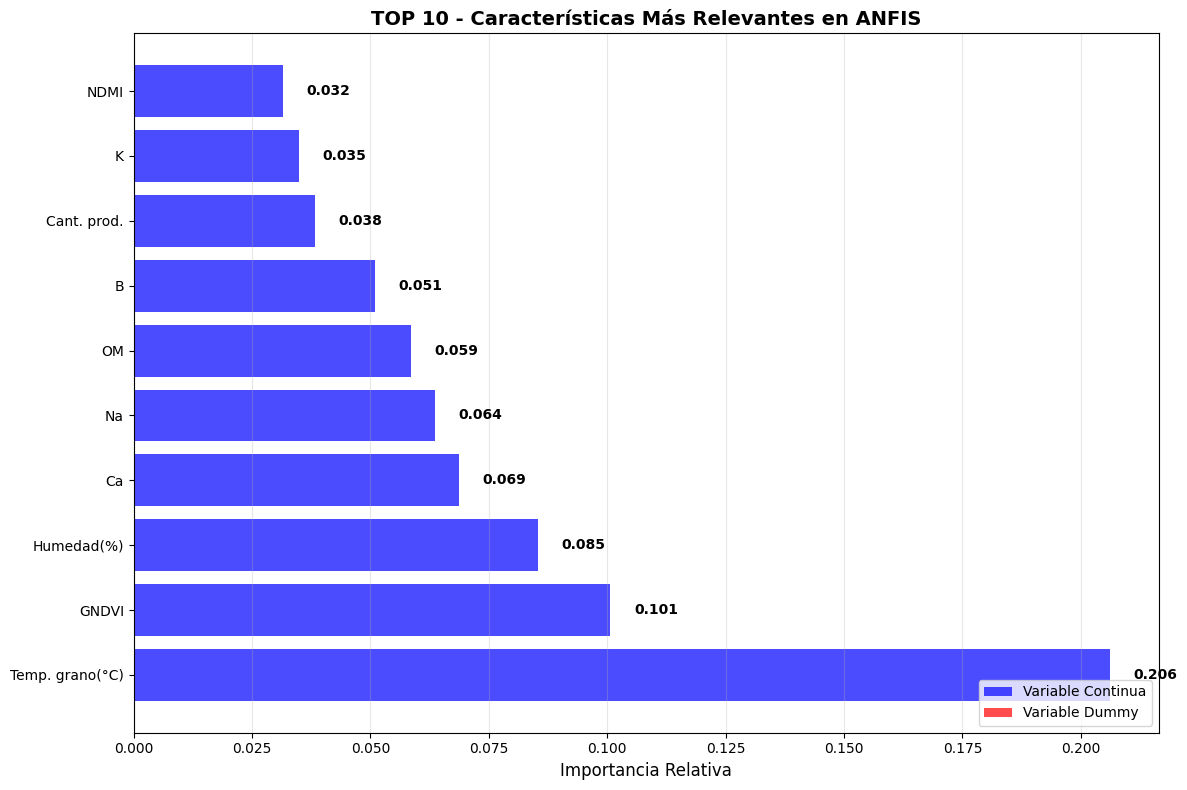


 FUNCIONES DE MEMBRESÍA - TOP 10 CONTINUAS


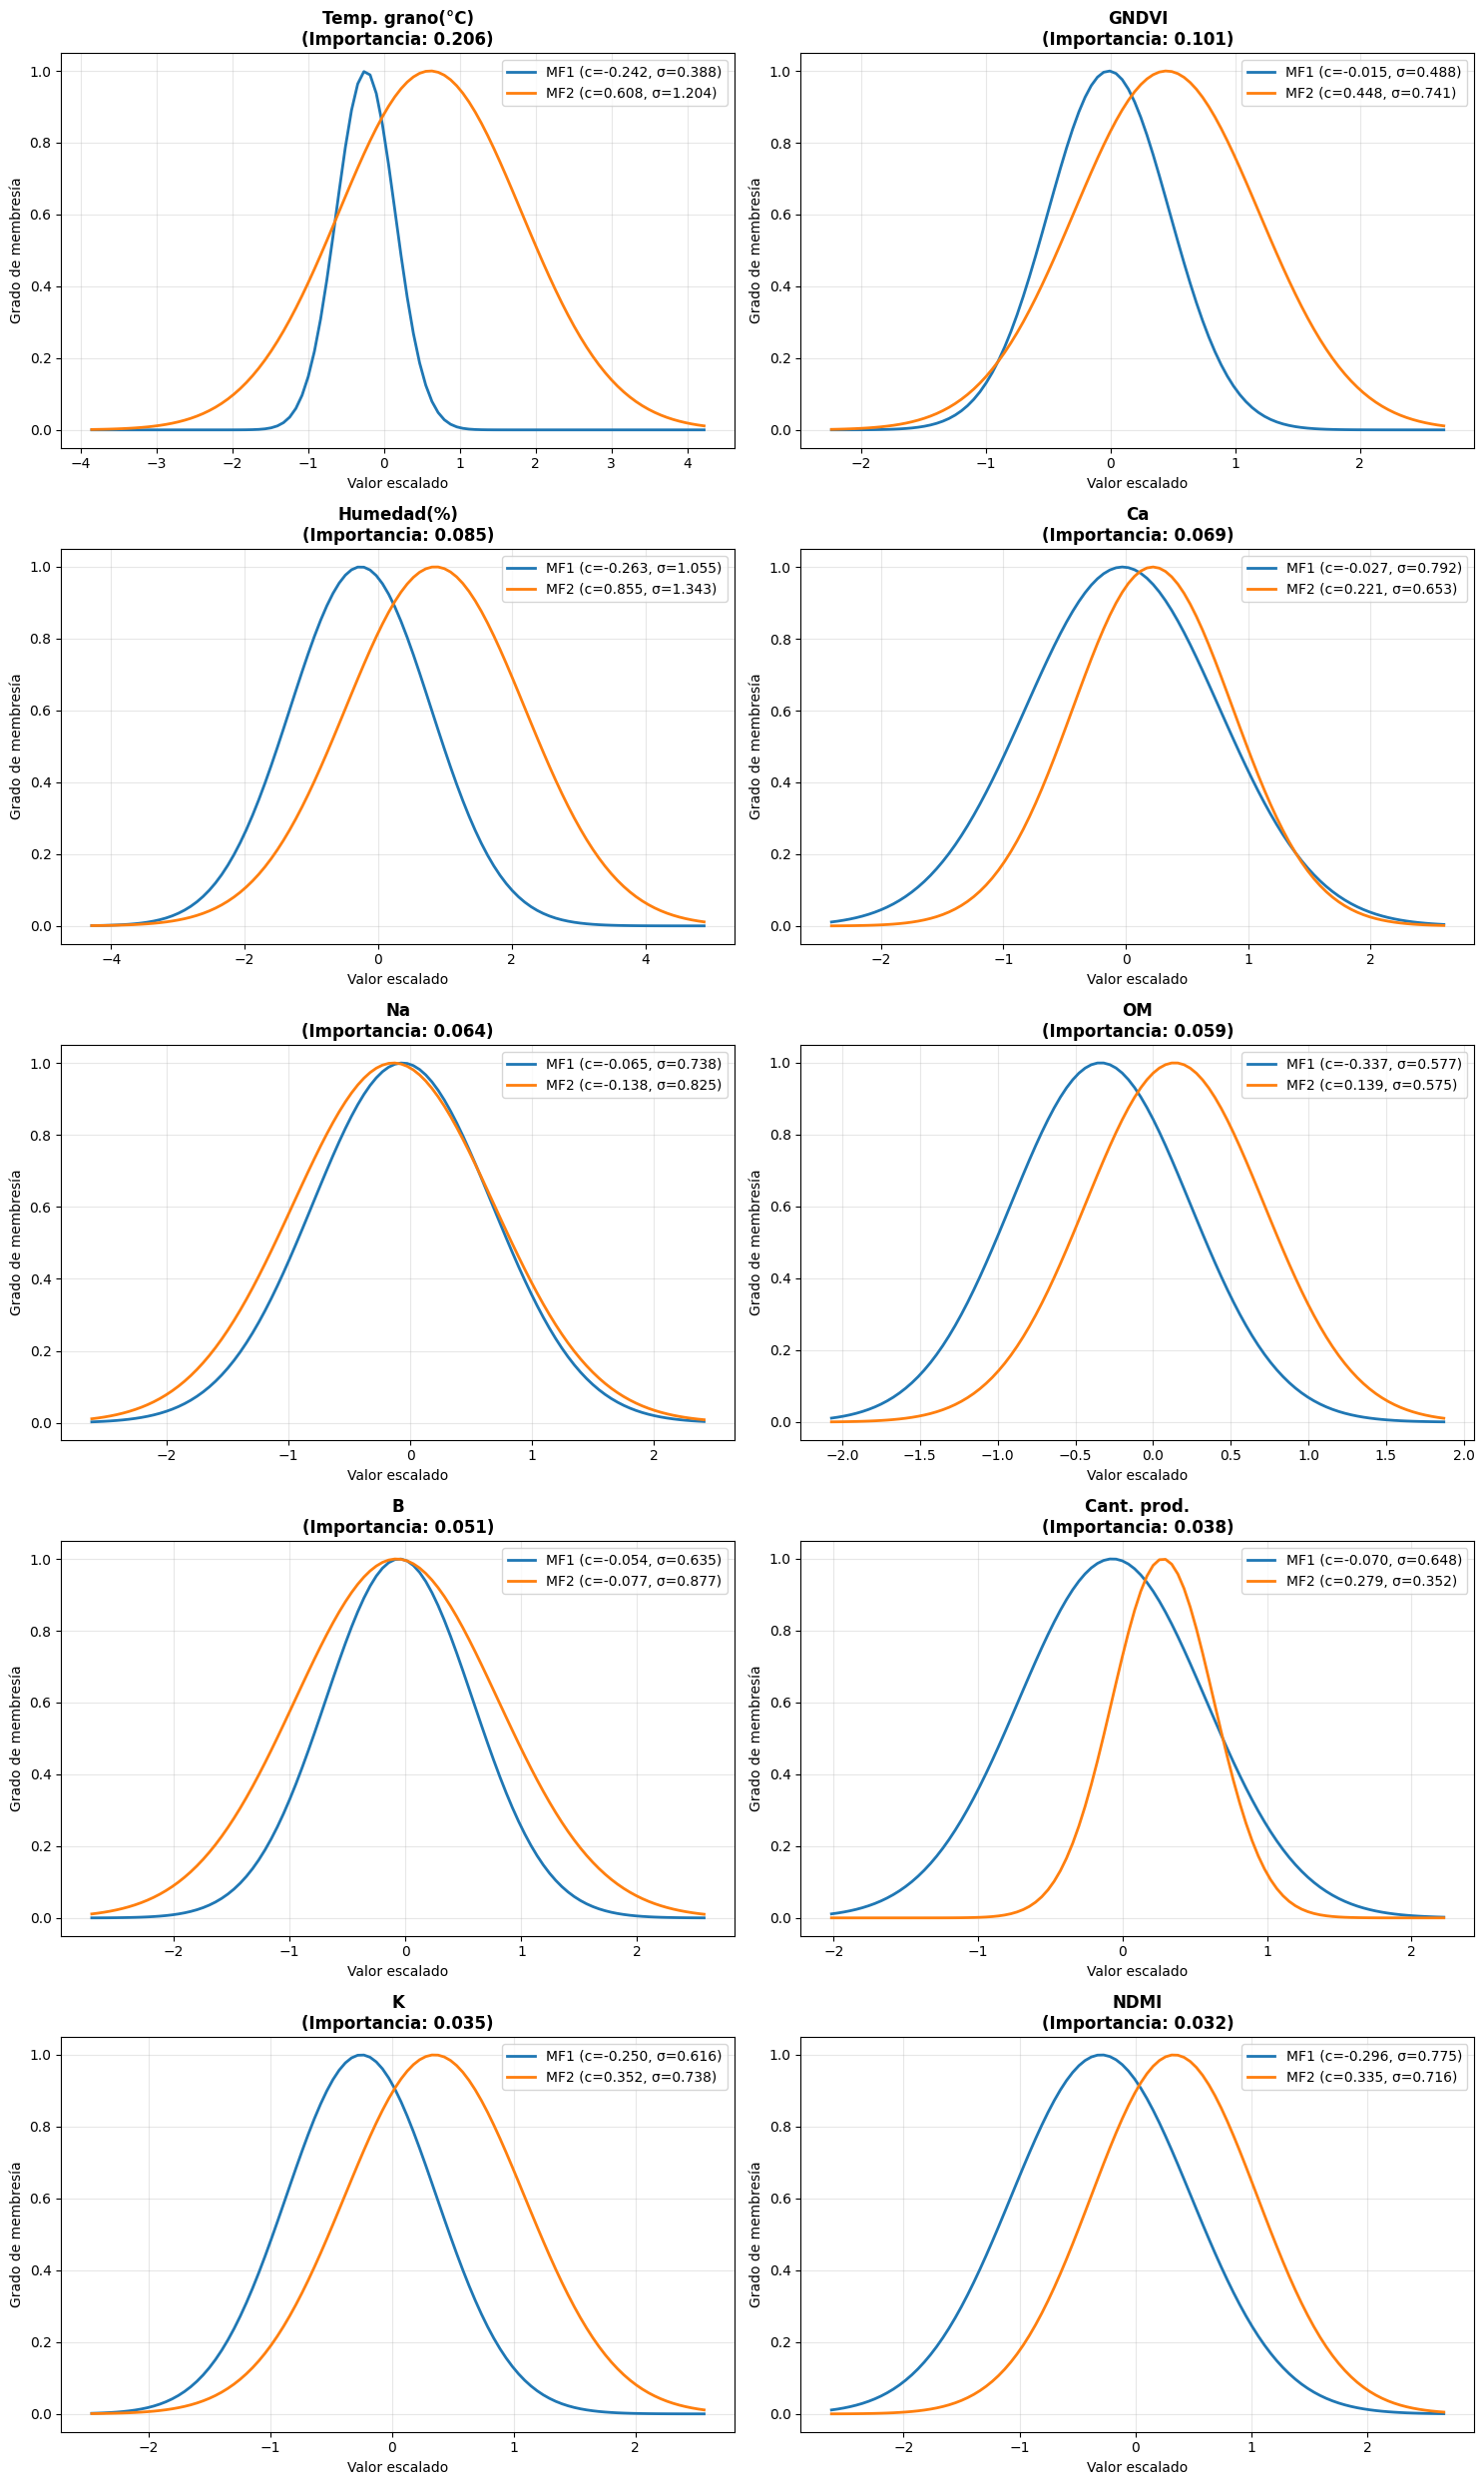


 RESUMEN EJECUTIVO - TOP 10 CARACTERÍSTICAS

 CARACTERÍSTICAS MÁS INFLUYENTES:

1. Temp. grano(°C) (🔵 Continua)
   • Importancia: 0.206
   • MF1: centro=-0.242, sigma=0.388
   • MF2: centro=0.608, sigma=1.204

2. GNDVI (🔵 Continua)
   • Importancia: 0.101
   • MF1: centro=-0.015, sigma=0.488
   • MF2: centro=0.448, sigma=0.741

3. Humedad(%) (🔵 Continua)
   • Importancia: 0.085
   • MF1: centro=-0.263, sigma=1.055
   • MF2: centro=0.855, sigma=1.343

4. Ca (🔵 Continua)
   • Importancia: 0.069
   • MF1: centro=-0.027, sigma=0.792
   • MF2: centro=0.221, sigma=0.653

5. Na (🔵 Continua)
   • Importancia: 0.064
   • MF1: centro=-0.065, sigma=0.738
   • MF2: centro=-0.138, sigma=0.825

6. OM (🔵 Continua)
   • Importancia: 0.059
   • MF1: centro=-0.337, sigma=0.577
   • MF2: centro=0.139, sigma=0.575

7. B (🔵 Continua)
   • Importancia: 0.051
   • MF1: centro=-0.054, sigma=0.635
   • MF2: centro=-0.077, sigma=0.877

8. Cant. prod. (🔵 Continua)
   • Importancia: 0.038
   • MF1: centro=-0.070

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# Configuración
# ----------------------------
CSV_PATH = "Par.csv"
TARGET_COL = "(seco)Masa de rend.(tonne/ha)"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_MFS = 2
HIDDEN_DIM = 118
DROPOUT_RATE = 0.3

# ----------------------------
# Clase del modelo
# ----------------------------
class RegularizedANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs=2, hidden_dim=128, dropout_rate=0.3):
        super(RegularizedANFIS, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs

        self.centers = nn.Parameter(torch.randn(input_dim, num_mfs) * 0.1)
        self.sigmas = nn.Parameter(torch.ones(input_dim, num_mfs) * 0.8)

        self.fuzzy_net = nn.Sequential(
            nn.Linear(input_dim * num_mfs, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(hidden_dim // 4, 1)
        )

    def gaussian_mf(self, x, centers, sigmas):
        return torch.exp(-0.5 * ((x.unsqueeze(-1) - centers) / (sigmas + 1e-8)) ** 2)

    def forward(self, x):
        batch_size = x.shape[0]
        membership = self.gaussian_mf(x, self.centers, self.sigmas)
        fuzzy_features = membership.reshape(batch_size, -1)
        output = self.fuzzy_net(fuzzy_features)
        return output.squeeze(1)

# ----------------------------
# Cargar datos
# ----------------------------
print(" Cargando datos...")
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=['parcela'])
cat_cols = ['Cal sing', 'Rate Qual']
df = pd.get_dummies(df, columns=cat_cols)

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(float).values

# Escalador
scaler_X = StandardScaler().fit(X)

# Obtener TODOS los nombres de características
all_feature_names = list(X.columns)
continuous_features = [col for col in X.columns if not any(cat in col for cat in cat_cols)]
dummy_features = [col for col in X.columns if any(cat in col for cat in cat_cols)]

print(f"Total características: {len(all_feature_names)}")
print(f"Continuas: {len(continuous_features)}, Dummy: {len(dummy_features)}")

# ----------------------------
# Cargar modelo entrenado
# ----------------------------
print("\n Cargando modelo entrenado...")
model = RegularizedANFIS(
    input_dim=X.shape[1],
    num_mfs=NUM_MFS,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

model.load_state_dict(torch.load('best_anfis_model.pth', map_location=DEVICE))
model.eval()
print(" Modelo cargado exitosamente!")

# ----------------------------
# Análisis de importancia (y filtrar top 10)
# ----------------------------
def analyze_top10_features(model, all_feature_names, scaler, original_data, n_samples=1000, top_k=10):
    """Analiza importancia y devuelve solo el top 10"""

    print("\n" + "=" * 80)
    print(f" ANALIZANDO TOP {top_k} CARACTERÍSTICAS MÁS IMPORTANTES")
    print("=" * 80)

    X_scaled = scaler.transform(original_data)
    X_sample = torch.tensor(X_scaled[:n_samples], dtype=torch.float32, device=DEVICE)

    with torch.no_grad():
        original_pred = model(X_sample)
        feature_importance = []

        for i in range(len(all_feature_names)):
            X_perturbed = X_sample.clone()
            X_perturbed[:, i] = X_perturbed[:, i].mean()
            perturbed_pred = model(X_perturbed)
            importance = nn.MSELoss()(original_pred, perturbed_pred).item()
            feature_importance.append(importance)

    # Normalizar
    feature_importance = np.array(feature_importance)
    if feature_importance.sum() > 0:
        feature_importance = feature_importance / feature_importance.sum()

    # DataFrame
    centers = model.centers.detach().cpu().numpy()
    sigmas = model.sigmas.detach().cpu().numpy()

    feature_types = []
    for feature in all_feature_names:
        if feature in continuous_features:
            feature_types.append("Continua")
        else:
            feature_types.append("Dummy")

    importance_df = pd.DataFrame({
        'Característica': all_feature_names,
        'Tipo': feature_types,
        'Importancia': feature_importance,
        'Centro_MF1': centers[:, 0],
        'Sigma_MF1': sigmas[:, 0],
        'Centro_MF2': centers[:, 1],
        'Sigma_MF2': sigmas[:, 1]
    }).sort_values('Importancia', ascending=False)

    # Filtrar top 10
    top10_df = importance_df.head(top_k).copy()

    print(f"\n TOP {top_k} CARACTERÍSTICAS MÁS IMPORTANTES:")
    print(top10_df.round(4))

    return top10_df, importance_df

# ----------------------------
# Visualización del TOP 10
# ----------------------------
def visualize_top10_importance(top10_df):
    """Visualiza solo el top 10 de características"""

    plt.figure(figsize=(12, 8))

    # Colores por tipo
    colors = ['blue' if typ == 'Continua' else 'red' for typ in top10_df['Tipo']]

    # Crear gráfico horizontal
    bars = plt.barh(range(len(top10_df)), top10_df['Importancia'], color=colors, alpha=0.7)

    # Configurar el gráfico
    plt.yticks(range(len(top10_df)), top10_df['Característica'])
    plt.xlabel('Importancia Relativa', fontsize=12)
    plt.title(f'TOP 10 - Características Más Relevantes en ANFIS', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

    # Añadir valores en las barras
    for i, (bar, value) in enumerate(zip(bars, top10_df['Importancia'])):
        plt.text(bar.get_width() + 0.005, i,
                f'{value:.3f}',
                ha='left', va='center',
                fontsize=10, fontweight='bold')

    # Añadir leyenda de tipos
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Variable Continua'),
        Patch(facecolor='red', alpha=0.7, label='Variable Dummy')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

# ----------------------------
# Visualización de MFs para TOP 10 continuas
# ----------------------------
def visualize_top10_mf(model, top10_df, all_feature_names, num_samples=100):
    """Visualiza funciones de membresía para las variables continuas del top 10"""

    # Filtrar solo las continuas del top 10
    top10_continuous = top10_df[top10_df['Tipo'] == 'Continua']

    if len(top10_continuous) == 0:
        print("No hay variables continuas en el top 10")
        return

    print(f"\n" + "=" * 80)
    print(f" FUNCIONES DE MEMBRESÍA - TOP {len(top10_continuous)} CONTINUAS")
    print("=" * 80)

    centers = model.centers.detach().cpu().numpy()
    sigmas = model.sigmas.detach().cpu().numpy()

    # Obtener índices reales en el modelo
    all_features_list = list(all_feature_names)

    n_features = len(top10_continuous)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (_, row) in enumerate(top10_continuous.iterrows()):
        feature_name = row['Característica']
        importance = row['Importancia']
        i = all_features_list.index(feature_name)  # Índice real

        ax = axes[idx]

        # Crear rango de valores
        feature_centers = centers[i]
        feature_sigmas = sigmas[i]

        x_min = feature_centers.min() - 3 * feature_sigmas.max()
        x_max = feature_centers.max() + 3 * feature_sigmas.max()
        x_range = np.linspace(x_min, x_max, num_samples)

        # Calcular valores de membresía
        for mf_idx in range(model.num_mfs):
            membership = np.exp(-0.5 * ((x_range - centers[i, mf_idx]) / (sigmas[i, mf_idx] + 1e-8)) ** 2)
            ax.plot(x_range, membership,
                   label=f'MF{mf_idx+1} (c={centers[i, mf_idx]:.3f}, σ={sigmas[i, mf_idx]:.3f})',
                   linewidth=2)

        ax.set_title(f'{feature_name}\n(Importancia: {importance:.3f})', fontweight='bold')
        ax.set_xlabel('Valor escalado')
        ax.set_ylabel('Grado de membresía')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Ocultar ejes vacíos
    for idx in range(len(top10_continuous), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Resumen ejecutivo del TOP 10
# ----------------------------
def generate_top10_summary(top10_df):
    """Genera resumen del top 10"""

    print("\n" + "=" * 80)
    print(" RESUMEN EJECUTIVO - TOP 10 CARACTERÍSTICAS")
    print("=" * 80)

    print(f"\n CARACTERÍSTICAS MÁS INFLUYENTES:")

    for idx, (_, row) in enumerate(top10_df.iterrows(), 1):
        feature_type = "🔵 Continua" if row['Tipo'] == 'Continua' else "🔴 Dummy"
        print(f"\n{idx}. {row['Característica']} ({feature_type})")
        print(f"   • Importancia: {row['Importancia']:.3f}")
        print(f"   • MF1: centro={row['Centro_MF1']:.3f}, sigma={row['Sigma_MF1']:.3f}")
        print(f"   • MF2: centro={row['Centro_MF2']:.3f}, sigma={row['Sigma_MF2']:.3f}")

    # Estadísticas
    n_continuous = len(top10_df[top10_df['Tipo'] == 'Continua'])
    n_dummy = len(top10_df[top10_df['Tipo'] == 'Dummy'])

    print(f"\n ESTADÍSTICAS DEL TOP 10:")
    print(f"   • Variables continuas: {n_continuous}")
    print(f"   • Variables dummy: {n_dummy}")
    print(f"   • Importancia total acumulada: {top10_df['Importancia'].sum():.3f}")

# ----------------------------
# EJECUCIÓN PRINCIPAL
# ----------------------------
if __name__ == "__main__":
    # 1. Analizar y obtener top 10
    top10_df, full_importance_df = analyze_top10_features(
        model, all_feature_names, scaler_X, X, top_k=10
    )

    # 2. Visualizar importancia del top 10
    visualize_top10_importance(top10_df)

    # 3. Visualizar MFs del top 10 (solo continuas)
    visualize_top10_mf(model, top10_df, all_feature_names)

    # 4. Generar resumen ejecutivo
    generate_top10_summary(top10_df)

    print(f"\n Análisis del TOP 10 completado!")
    print(f"   Total de características analizadas: {len(full_importance_df)}")
    print(f"   Top 10 representa el {top10_df['Importancia'].sum()*100:.1f}% de la importancia total")

Dimensiones de X: (10830, 8)
Columnas de X: ['GNDVI', 'Ca', 'Na', 'OM', 'B', 'Cant. prod.', 'K', 'NDMI']
Modelo ANFIS creado con 46497 parámetros
Hiperparámetros: MFs=2, Hidden=256, Dropout=0.3, WD=0.001
Epoch 1/500 - LR: 0.00100000
  Train - MSE: 92.1403, RMSE: 9.5990, MAE: 8.8471, R²: -4.0782
  Test  - MSE: 76.1711, RMSE: 8.7276, MAE: 7.8769, R²: -3.1319
  Gap Train-Test: MSE=+15.9692, RMSE=+0.8714

Epoch 2/500 - LR: 0.00100000
  Train - MSE: 67.8266, RMSE: 8.2357, MAE: 7.5049, R²: -2.7382
  Test  - MSE: 57.2104, RMSE: 7.5638, MAE: 6.8275, R²: -2.1034
  Gap Train-Test: MSE=+10.6162, RMSE=+0.6719

Epoch 3/500 - LR: 0.00100000
  Train - MSE: 48.3241, RMSE: 6.9516, MAE: 6.1961, R²: -1.6633
  Test  - MSE: 37.7833, RMSE: 6.1468, MAE: 5.3845, R²: -1.0496
  Gap Train-Test: MSE=+10.5408, RMSE=+0.8047

Epoch 4/500 - LR: 0.00100000
  Train - MSE: 33.3435, RMSE: 5.7744, MAE: 5.0140, R²: -0.8377
  Test  - MSE: 26.9598, RMSE: 5.1923, MAE: 4.4512, R²: -0.4624
  Gap Train-Test: MSE=+6.3837, RMSE=+0

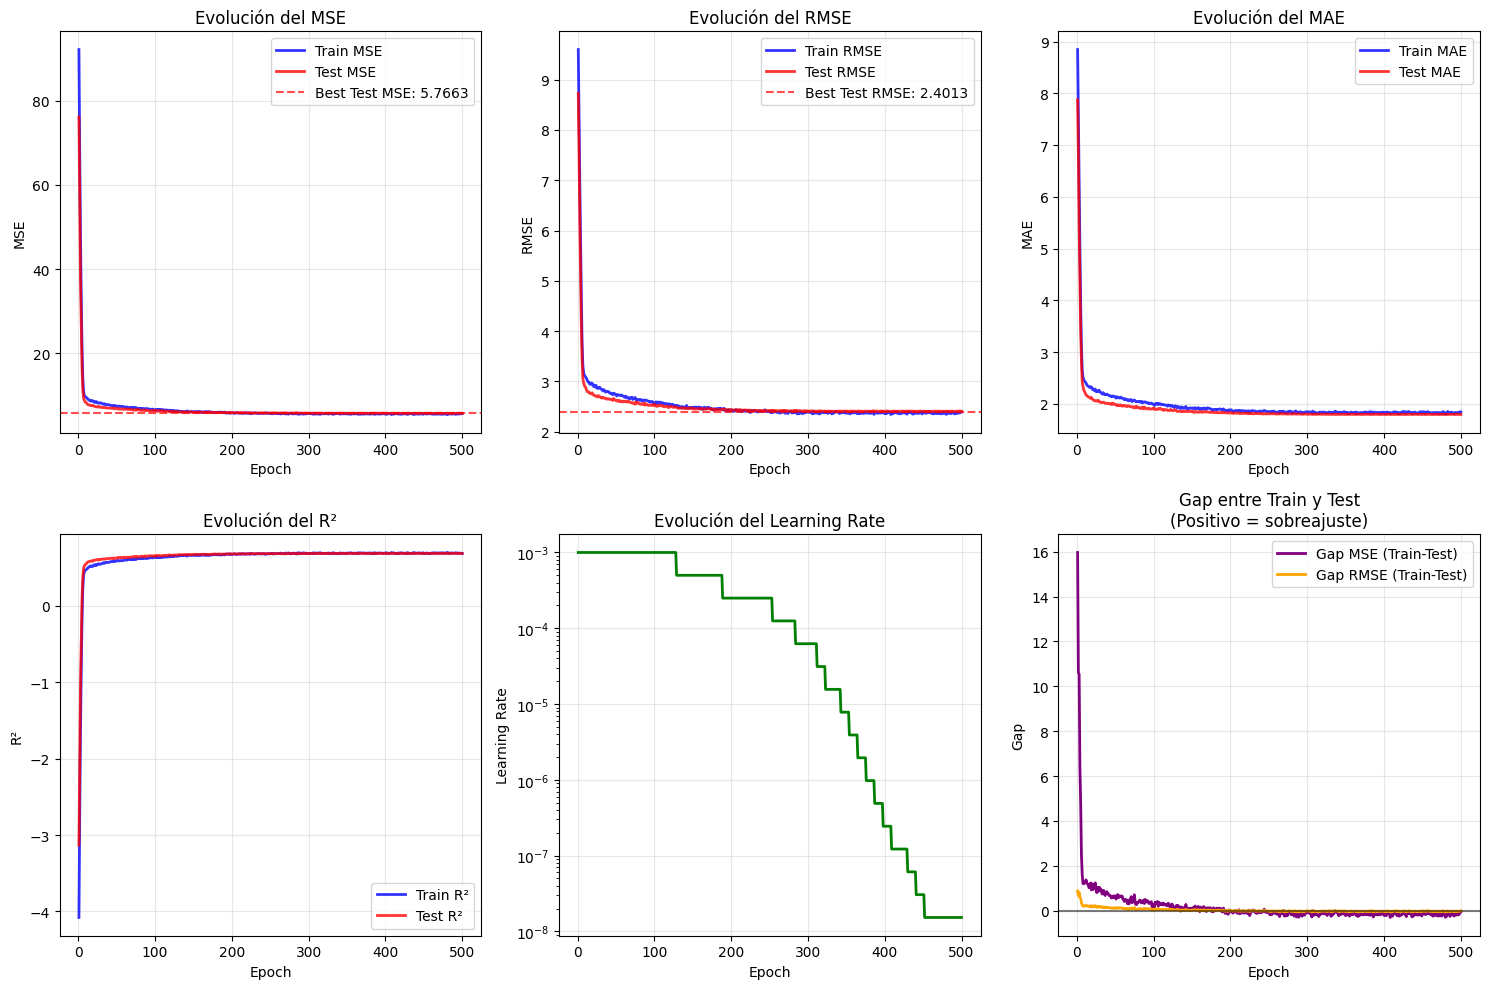

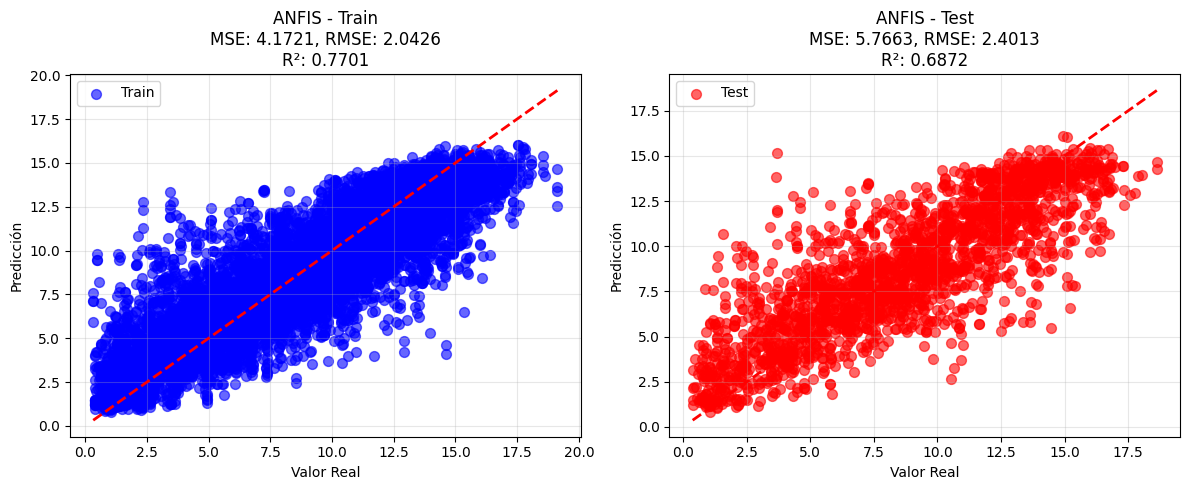


RESUMEN FINAL DE MÉTRICAS ANFIS
Métrica         Train        Test         Gap         
------------------------------------------------------------
MSE             4.1721     5.7663     -1.5942
RMSE            2.0426     2.4013     -0.3587
MAE             1.5384     1.7955     -0.2571
R²              0.7701     0.6872     +0.0829

 ANÁLISIS DE SOBREAJUSTE:
   Gap RMSE (Train-Test): -0.3587
 SIN SOBREAJUSTE 

 Hiperparámetros actuales:
   • NUM_MFS = 2
   • HIDDEN_DIM = 256
   • DROPOUT_RATE = 0.3
   • WEIGHT_DECAY = 0.001
   • BATCH_SIZE = 256


In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt
import time

# ----------------------------
# Config con Hiperparámetros Ajustables
# ----------------------------
CSV_PATH = "Par.csv"
TARGET_COL = "(seco)Masa de rend.(tonne/ha)"
TEST_SIZE = 0.2
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# HIPERPARÁMETROS AJUSTABLES
EPOCHS = 500
BATCH_SIZE = 256
LR = 0.001
NUM_MFS = 2
HIDDEN_DIM = 128
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-3

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ----------------------------
# Carga de datos
# ----------------------------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=['parcela'])
cat_cols = ['Cal sing', 'Rate Qual']
df = pd.get_dummies(df, columns=cat_cols)

if TARGET_COL not in df.columns:
    raise ValueError(f"No encontré la columna target '{TARGET_COL}'")

X = df[['Temp. grano(°C)','GNDVI', 'Humedad(%)', 'Ca', 'Na', 'OM', 'B', 'Cant. prod.', 'K', 'NDMI']]
y = df[TARGET_COL].astype(float).values

print(f"Dimensiones de X: {X.shape}")
print(f"Columnas de X: {list(X.columns)}")

# Escalado
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Modelo ANFIS
# ----------------------------
class RegularizedANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs=2, hidden_dim=128, dropout_rate=0.3):
        super(RegularizedANFIS, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs

        # Inicialización más conservadora de centros y sigmas
        self.centers = nn.Parameter(torch.randn(input_dim, num_mfs) * 0.1)
        self.sigmas = nn.Parameter(torch.ones(input_dim, num_mfs) * 0.8)

        # Arquitectura
        self.fuzzy_net = nn.Sequential(
            nn.Linear(input_dim * num_mfs, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),

            nn.Linear(hidden_dim // 4, 1)
        )

        # Inicialización de pesos
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def gaussian_mf(self, x, centers, sigmas):
        return torch.exp(-0.5 * ((x.unsqueeze(-1) - centers) / (sigmas + 1e-8)) ** 2)

    def forward(self, x):
        batch_size = x.shape[0]
        membership = self.gaussian_mf(x, self.centers, self.sigmas)
        fuzzy_features = membership.view(batch_size, -1)
        output = self.fuzzy_net(fuzzy_features)
        return output.squeeze(1)

# Crear modelo con hiperparámetros
model = RegularizedANFIS(
    input_dim=X_train.shape[1],
    num_mfs=NUM_MFS,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

# Optimizador con weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
loss_fn = nn.MSELoss()

print(f"Modelo ANFIS creado con {sum(p.numel() for p in model.parameters())} parámetros")
print(f"Hiperparámetros: MFs={NUM_MFS}, Hidden={HIDDEN_DIM}, Dropout={DROPOUT_RATE}, WD={WEIGHT_DECAY}")

# ----------------------------
# Entrenamiento
# ----------------------------
train_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}
test_metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}
learning_rates = []

start = time.time()
best_test_rmse = float('inf')
best_test_mse = float('inf')

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    y_train_pred = []
    y_train_true = []
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        y_train_pred.append(preds.detach().cpu().numpy())
        y_train_true.append(yb.cpu().numpy())

    # Métricas de entrenamiento
    y_train_pred = np.concatenate(y_train_pred)
    y_train_true = np.concatenate(y_train_true)
    train_mse = mean_squared_error(y_train_true, y_train_pred)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = math.sqrt(train_mse)
    train_r2 = r2_score(y_train_true, y_train_pred)

    # Test
    model.eval()
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_pred_test.append(preds.cpu().numpy())
            y_true_test.append(yb.cpu().numpy())

    y_pred_test = np.concatenate(y_pred_test)
    y_true_test = np.concatenate(y_true_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = math.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Actualizar scheduler
    scheduler.step(test_mse)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Guardamos el mejor modelo
    if test_mse < best_test_mse:
        best_train_mse = train_mse
        best_train_rsme = train_rmse
        best_train_mae = train_mae
        best_train_r2 = train_r2
        best_test_mse = test_mse
        best_test_rmse = test_rmse
        best_test_mae = test_mae
        best_test_r2 = test_r2
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_anfis_model_10.pth')

    # Guardar métricas
    train_metrics['mse'].append(train_mse)
    train_metrics['rmse'].append(train_rmse)
    train_metrics['mae'].append(train_mae)
    train_metrics['r2'].append(train_r2)

    test_metrics['mse'].append(test_mse)
    test_metrics['rmse'].append(test_rmse)
    test_metrics['mae'].append(test_mae)
    test_metrics['r2'].append(test_r2)

    if epoch % 10 == 0 or epoch <= 5:
        print(f"Epoch {epoch}/{EPOCHS} - LR: {current_lr:.8f}")
        print(f"  Train - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
        print(f"  Test  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
        print(f"  Gap Train-Test: MSE={train_mse-test_mse:+.4f}, RMSE={train_rmse-test_rmse:+.4f}")
        print()

elapsed = time.time() - start
print(f"\nEntrenamiento ANFIS completado en {elapsed/60:.2f} minutos")
print(f"Mejor epoch: {best_epoch}")
print(f"Best MSE: {best_train_mse:.4f}")
print(f"Best RMSE: {best_train_rsme:.4f}")
print(f"Best MAE: {best_train_mae:.4f}")
print(f"Best RMSE: {best_train_r2:.4f}")
print(f"Mejor Test MSE:  {best_test_mse:.4f}")
print(f"Mejor Test RMSE: {best_test_rmse:.4f}")
print(f"Mejor Test MAE:  {best_test_mae:.4f}")
print(f"Mejor Test R2: {best_test_r2:.4f}")

# Cargar el mejor modelo al final
model.load_state_dict(torch.load('best_anfis_model_10.pth'))

# ----------------------------
# Visualización Completa de Resultados
# ----------------------------
# Asegurarnos que todas las métricas tengan la misma longitud
min_length = min(len(train_metrics['mse']), len(test_metrics['mse']))
epochs_range = range(1, min_length + 1)

# Recortar todas las métricas a la misma longitud
train_metrics_corr = {k: v[:min_length] for k, v in train_metrics.items()}
test_metrics_corr = {k: v[:min_length] for k, v in test_metrics.items()}
learning_rates_corr = learning_rates[:min_length]

plt.figure(figsize=(15, 10))

# MSE y RMSE
plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_metrics_corr['mse'], 'b-', label='Train MSE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['mse'], 'r-', label='Test MSE', linewidth=2, alpha=0.8)
plt.axhline(y=best_test_mse, color='r', linestyle='--', alpha=0.7, label=f'Best Test MSE: {best_test_mse:.4f}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Evolución del MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE
plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_metrics_corr['rmse'], 'b-', label='Train RMSE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['rmse'], 'r-', label='Test RMSE', linewidth=2, alpha=0.8)
plt.axhline(y=best_test_rmse, color='r', linestyle='--', alpha=0.7, label=f'Best Test RMSE: {best_test_rmse:.4f}')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Evolución del RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE
plt.subplot(2, 3, 3)
plt.plot(epochs_range, train_metrics_corr['mae'], 'b-', label='Train MAE', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['mae'], 'r-', label='Test MAE', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Evolución del MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# R²
plt.subplot(2, 3, 4)
plt.plot(epochs_range, train_metrics_corr['r2'], 'b-', label='Train R²', linewidth=2, alpha=0.8)
plt.plot(epochs_range, test_metrics_corr['r2'], 'r-', label='Test R²', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Evolución del R²')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate
plt.subplot(2, 3, 5)
plt.plot(epochs_range, learning_rates_corr, 'g-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Gap entre train y test (sobreajuste)
plt.subplot(2, 3, 6)
train_test_gap_mse = np.array(train_metrics_corr['mse']) - np.array(test_metrics_corr['mse'])
train_test_gap_rmse = np.array(train_metrics_corr['rmse']) - np.array(test_metrics_corr['rmse'])
plt.plot(epochs_range, train_test_gap_mse, 'purple', label='Gap MSE (Train-Test)', linewidth=2)
plt.plot(epochs_range, train_test_gap_rmse, 'orange', label='Gap RMSE (Train-Test)', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.title('Gap entre Train y Test\n(Positivo = sobreajuste)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Predicciones vs Valores Reales
# ----------------------------
model.eval()
with torch.no_grad():
    y_train_pred_final = model(X_train_t).cpu().numpy()
    y_test_pred_final = model(X_test_t).cpu().numpy()

# Métricas finales detalladas
final_train_mse = mean_squared_error(y_train, y_train_pred_final)
final_test_mse = mean_squared_error(y_test, y_test_pred_final)
final_train_rmse = math.sqrt(final_train_mse)
final_test_rmse = math.sqrt(final_test_mse)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_final, alpha=0.6, s=50, c='blue', label='Train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title(f'ANFIS - Train\nMSE: {final_train_mse:.4f}, RMSE: {final_train_rmse:.4f}\nR²: {r2_score(y_train, y_train_pred_final):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_final, alpha=0.6, s=50, c='red', label='Test')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title(f'ANFIS - Test\nMSE: {final_test_mse:.4f}, RMSE: {final_test_rmse:.4f}\nR²: {r2_score(y_test, y_test_pred_final):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Resumen Final de Métricas
# ----------------------------
print("\n" + "="*60)
print("RESUMEN FINAL DE MÉTRICAS ANFIS")
print("="*60)
print(f"{'Métrica':<15} {'Train':<12} {'Test':<12} {'Gap':<12}")
print("-" * 60)
print(f"{'MSE':<15} {final_train_mse:.4f}     {final_test_mse:.4f}     {final_train_mse-final_test_mse:+.4f}")
print(f"{'RMSE':<15} {final_train_rmse:.4f}     {final_test_rmse:.4f}     {final_train_rmse-final_test_rmse:+.4f}")
print(f"{'MAE':<15} {mean_absolute_error(y_train, y_train_pred_final):.4f}     {mean_absolute_error(y_test, y_test_pred_final):.4f}     {mean_absolute_error(y_train, y_train_pred_final)-mean_absolute_error(y_test, y_test_pred_final):+.4f}")
print(f"{'R²':<15} {r2_score(y_train, y_train_pred_final):.4f}     {r2_score(y_test, y_test_pred_final):.4f}     {r2_score(y_train, y_train_pred_final)-r2_score(y_test, y_test_pred_final):+.4f}")
print("="*60)

# ----------------------------
# Recomendaciones de Hiperparámetros
# ----------------------------
overfitting_gap = final_train_rmse - final_test_rmse
print("\n ANÁLISIS DE SOBREAJUSTE:")
print(f"   Gap RMSE (Train-Test): {overfitting_gap:+.4f}")

if overfitting_gap > 0.1:
    print(" ALTO SOBREAJUSTE ")
elif overfitting_gap > 0.05:
    print(" SOBREAJUSTE MODERADO ")
elif overfitting_gap > 0:
    print(" SOBREAJUSTE LEVE ")
else:
    print(" SIN SOBREAJUSTE ")

print(f"\n Hiperparámetros actuales:")
print(f"   • NUM_MFS = {NUM_MFS}")
print(f"   • HIDDEN_DIM = {HIDDEN_DIM}")
print(f"   • DROPOUT_RATE = {DROPOUT_RATE}")
print(f"   • WEIGHT_DECAY = {WEIGHT_DECAY}")
print(f"   • BATCH_SIZE = {BATCH_SIZE}")